In [1]:
import numpy as np
import pandas as pd

# データの取り込み

# import data
data = pd.read_csv(r"./gender-classifier-DFE-791531.csv",encoding='latin1')

# concat gender and description
data = pd.concat([data.gender,data.description],axis=1)

#drop nan values inplace
data.dropna(inplace=True,axis=0)
data = data.reset_index(drop=True)

In [2]:
import re

def remove_urls(text):
    
    urls = [g[0] for g in re.findall(r'((https?|ftp)(:\/\/[-_\.!~*\'()a-zA-Z0-9;\/?:\@&=\+\$,%#]+))', text)]
    
    for url in sorted(urls,key=lambda x:-len(x)):
    
        text = text.replace(url,'')
        
    return text

In [3]:
data.gender.loc[data.gender == 'male']   = 0
data.gender.loc[data.gender == 'female'] = 1
data.gender.loc[~(data.gender == 0) & ~(data.gender == 1)] = np.nan

data.description = data.description.map(remove_urls)

data.dropna(inplace=True,axis=0)
data = data.reset_index(drop=True)
data.gender = data.gender.astype(int)

In [4]:
# preprocessing
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from collections import defaultdict,Counter

docs = []

w2i  = defaultdict(lambda : len(w2i))

mystopwords = stopwords.words('english') + ["i'm","rt"]

tokenizer = RegexpTokenizer("(?u)(?=[a-zA-Z])\\b[\w']{2,}\\b")

for text in data.description:

    tokens = tokenizer.tokenize(text)
    docs.append([w2i[w.lower()] for w in tokens if w.lower() not in mystopwords])

In [5]:
dim = len(w2i)
max_len = 20

In [6]:
from keras import preprocessing

x = preprocessing.sequence.pad_sequences(docs, maxlen=max_len)

Using TensorFlow backend.
/home/fukuyama/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
import numpy as np

y = np.asarray(data.gender.values).astype('float32')

In [8]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 0)

In [12]:
from keras import models
from keras import layers
from keras import optimizers
from keras import metrics
from keras import losses
from keras import regularizers
from keras.layers import Flatten, Dense, Embedding, SimpleRNN

model = models.Sequential()
model.add(Embedding(dim, 8, input_length=max_len))
model.add(SimpleRNN(8))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 8)             188904    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 189,049
Trainable params: 189,049
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 8059 samples, validate on 2015 samples
Epoch 1/10
8059/8059 [==============================] - 6s 685us/step - loss: 0.6860 - acc: 0.5504 - val_loss: 0.6791 - val_acc: 0.5653
Epoch 2/10
8059/8059 [==============================] - 3s 421us/step - loss: 0.6281 - acc: 0.6706 - val_loss: 0.6548 - val_acc: 0.6079
Epoch 3/10
8059/8059 [==============================] - 3s 433us/step - loss: 0.5151 - acc: 0.7649 - val_loss: 0.6805 - val_acc: 0.5816
Epoch 4/10
8059/8059 [==============================] - 3s 419us/step - loss: 0.4139 - acc: 0.8196 - val_loss: 0.7063 - val_acc: 0.6104
Epoch 5/10
8059/8059 [==============================] - 4s 443us/step - loss: 0.3296 - acc: 0.8631 - val_loss: 0.7504 - val_acc: 0.6094
Epoch 6/10
8059/8059 [==============================] - 4s 437us/step - loss: 0.2634 - acc: 0.8929 - val_loss: 0.8085 - val_acc: 0.6065
Epoch 7/10
8059/8059 [==============================] - 3s 432us/step - loss: 0.2161 - acc: 0.9159 - val_loss: 0.8636 - val_acc: 0.5995


In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

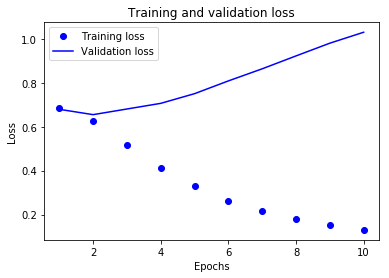

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

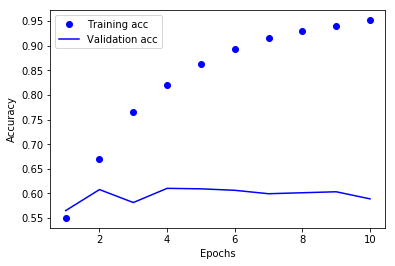

In [16]:
plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
results = model.evaluate(x_test, y_test)

1120/1120 [==============================] - 0s 145us/step


In [19]:
results

[0.96009658489908489, 0.61428571428571432]